In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.stats.composition import clr, centralize, ilr
from skbio import OrdinationResults
%matplotlib inline

In [95]:
def cart2polar(x, y):
    theta = np.arctan2(y, x)
    rho = np.sqrt(x**2 + y**2)
    return rho, theta

In [169]:
species = 'pelag'
category = 'latitude'
N = 50
legend_loc = 'lower right'

In [175]:
species = 'pelag'
category = 'temperature'
N = 50
legend_loc = 'lower right'

In [177]:
species = 'proch'
category = 'latitude'
N = 50
legend_loc = 'upper left'

In [179]:
species = 'proch'
category = 'temperature'
N = 50
legend_loc = 'upper left'

'/Users/luke/singlecell/notebooks/ordination_of_tara_results_proch_temperature.pc'

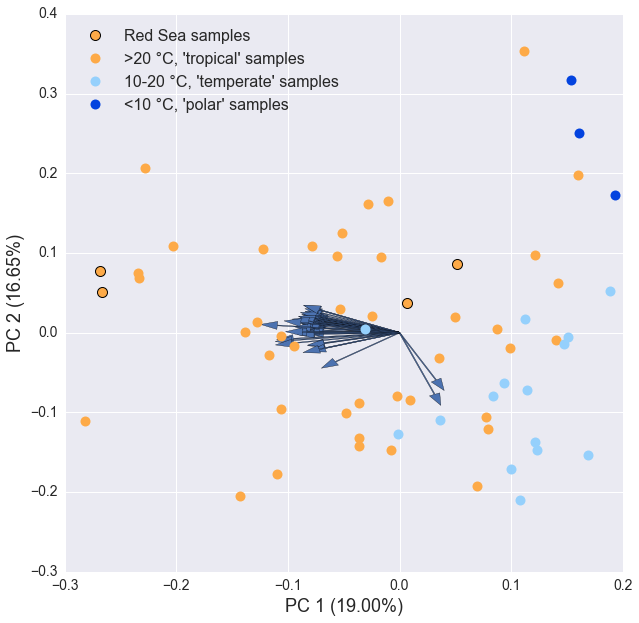

In [180]:
counts = pd.read_csv('/Users/luke/singlecell/notebooks/tara_%s_nonzero_SRF.csv' % species)

tara_metadata = pd.read_csv('/Users/luke/singlecell/notebooks/tara_metadata_SRF.tsv', sep='\t')
tara_metadata = tara_metadata.sort_values(by=r'Sample label [TARA_station#_environmental-feature_size-fraction]')

og_metadata = pd.read_csv('/Users/luke/singlecell/notebooks/og_metadata.tsv', sep='\t', index_col=0)

f = lambda x: x.split('_')[1]
tara_metadata['SampleNumber'] = tara_metadata[r'Sample label [TARA_station#_environmental-feature_size-fraction]'].apply(f)
counts['SampleNumber'] = counts[r'Unnamed: 0'].apply(f)

tara_metadata = tara_metadata.sort_values(by=r'SampleNumber')
counts = counts.sort_values(by=r'SampleNumber')

mat = counts.values[:, 1:-1]
mat = mat.astype(dtype=np.float)

u1, k1, v1 = np.linalg.svd(clr(centralize(mat+1)))

n = len(u1)
G = np.sqrt(n - 1) * u1[:, :2]
H = np.vstack(((np.sqrt(k1[0]) * v1[0, :]) / np.sqrt(n - 1), (np.sqrt(k1[1]) * v1[1, :]) / np.sqrt(n - 1)))

# Get top N hits
rho, theta = cart2polar(H[0, :], H[1, :])
z = rho.argsort()[-N:]

# Calculate radii and degrees to easier identification on the biplot
feats = pd.DataFrame({'rho':rho[z], 'theta':theta[z]*180/np.pi}, index=counts.columns[1:-1][z])
feats['Description'] = og_metadata['Description'][feats.index]
feats.sort_values(by='rho', ascending=False, inplace=True)
feats.to_csv('/Users/luke/singlecell/notebooks/ordination_of_tara_biplot_ogs_%s_%s.tsv' % (species, category), sep='\t')

# cat lookup
if category == 'temperature':
    dict_cat = {
        'polar': u"<10 \N{DEGREE SIGN}C, 'polar' samples",
        'temperate': u"10-20 \N{DEGREE SIGN}C, 'temperate' samples",
        'tropical': u">20 \N{DEGREE SIGN}C, 'tropical' samples"
        }
    colors = ['light orange', 'light blue', 'blue']
elif category == 'latitude':
    dict_cat = {
        'temperate': u'temperate samples',
        'subtropical': u'subtropical samples',
        'tropical': u'tropical samples'
        }
    colors = ['blue', 'light blue', 'light orange']

# plot
plt.figure(figsize=(10, 10))

marker_rs = dict(color=sns.xkcd_rgb['light orange'], marker='o', markeredgewidth=1, markeredgecolor='black')
idx = tara_metadata['category_redsea'] == True
p1 = plt.plot(u1[idx.values, 0], u1[idx.values, 1], '.', label='Red Sea samples', markersize=10, zorder=10, **marker_rs)

i = 0
for cat in set(tara_metadata['category_%s' % category]):
    idx = tara_metadata['category_%s' % category] == cat
    plt.plot(u1[idx.values, 0], u1[idx.values, 1], 'o', label=dict_cat[cat], markersize=10, color=sns.xkcd_rgb[colors[i]])
    i += 1

for j in z:
    _x, _y = H[0, j], H[1, j]
    plt.arrow(0, 0, _x, _y, head_width=0.01)    
perc_explained = k1**2 / (k1**2).sum()    
plt.xlabel('PC 1 ({:.2%})'.format(perc_explained[0]), fontsize=18)
plt.ylabel('PC 2 ({:.2%})'.format(perc_explained[1]), fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc=legend_loc)
plt.savefig('/Users/luke/singlecell/notebooks/ordination_of_tara_samples_%s_%s.pdf' % (species, category))

# ordination results
u = pd.DataFrame(u1, index=counts.index)
proportion_explained=pd.Series(perc_explained, index=counts.index)
eigvals=pd.Series(k1, index=counts.index)
res = OrdinationResults('','',samples=u, proportion_explained=proportion_explained, eigvals=eigvals)
res.write('/Users/luke/singlecell/notebooks/ordination_of_tara_results_%s_%s.pc' % (species, category))